**1.IMPOTING LIBRARIES**

In [1]:
# Standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model building and deployment
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

**2.LOAD AND INSPECT THE DATA**

In [2]:
# Load Apple stock data
df = pd.read_csv('AAPL.csv', parse_dates=['Date'])
print(df.head())
print(df.info())
print(df.describe())

        Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2011 non-null   datetime64[ns]
 1   Open       2011 non-null   float64       
 2   High       2011 non-null   float64       
 3   Low        2011 non-null   float64       
 4   Close      2011 non-null   float64       
 5   Adj Close  2011 non-null   float64       
 6   Volume     2011 non-null   int64         
dty

**3.DATA PREPROCESSING**

In [3]:
# Convert 'Date' to datetime and set as index for time-series analysis
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Check for missing values
print(df.isnull().sum())
# Fill or drop missing values if needed (Example: Forward Fill)
df.fillna(method='ffill', inplace=True)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


/tmp/ipython-input-3959430619.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [4]:
from sklearn.ensemble import IsolationForest

In [5]:
# Only use numeric features for outlier detection
num_cols = df.select_dtypes(include='number').columns

# Fit Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[num_cols])

# Remove outliers (anomaly = -1 are outliers)
df_clean = df[df['anomaly'] == 1].drop(columns=['anomaly'])
print("Removed", (df['anomaly'] == -1).sum(), "outliers")

Removed 21 outliers


**4.EXPLORATORY DATA ANALYSIS(EDA)**



*   Closing price trends



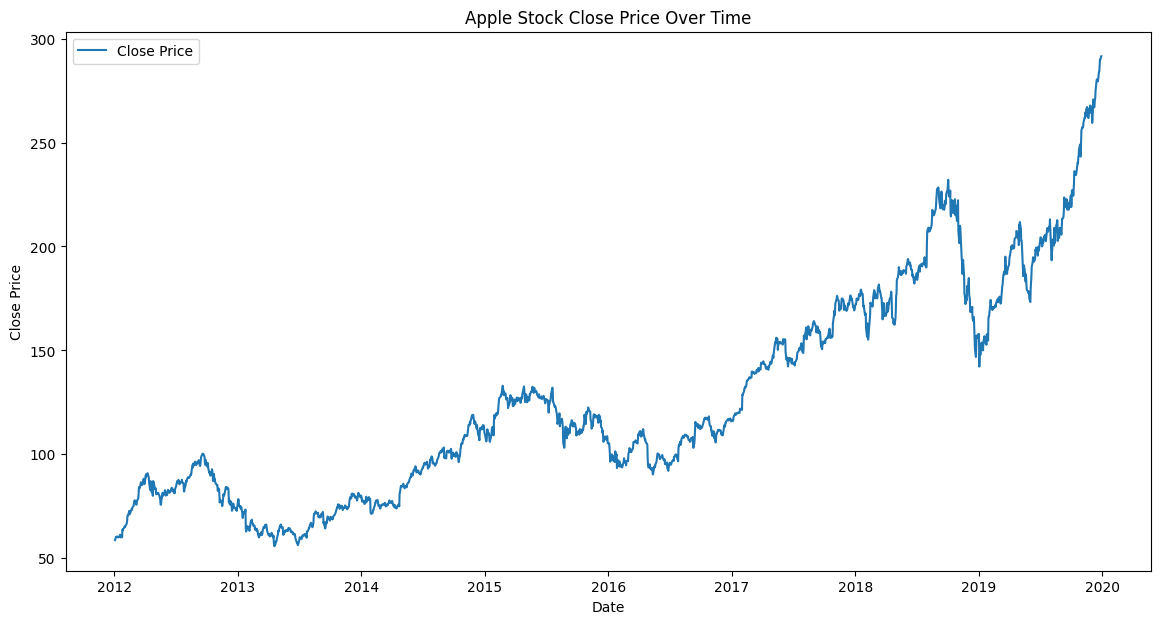

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.title('Apple Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



*   correlation matrix



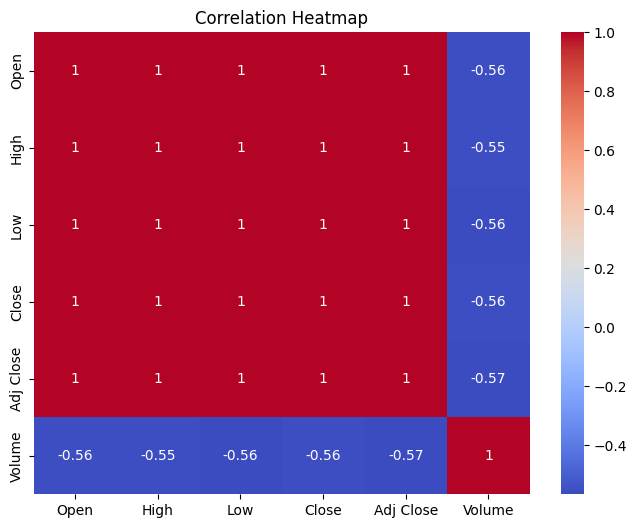

In [7]:
corr = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



*  Daily returns


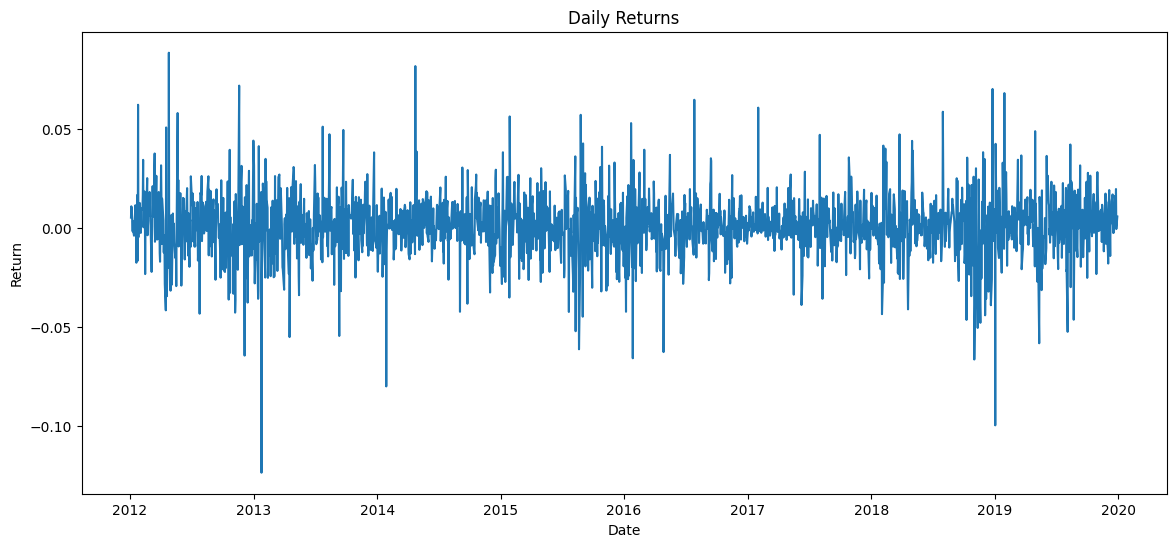

In [8]:
df['Returns'] = df['Close'].pct_change()
plt.figure(figsize=(14, 6))
plt.plot(df['Returns'])
plt.title('Daily Returns')
plt.ylabel('Return')
plt.xlabel('Date')
plt.show()



*  Volume analysis



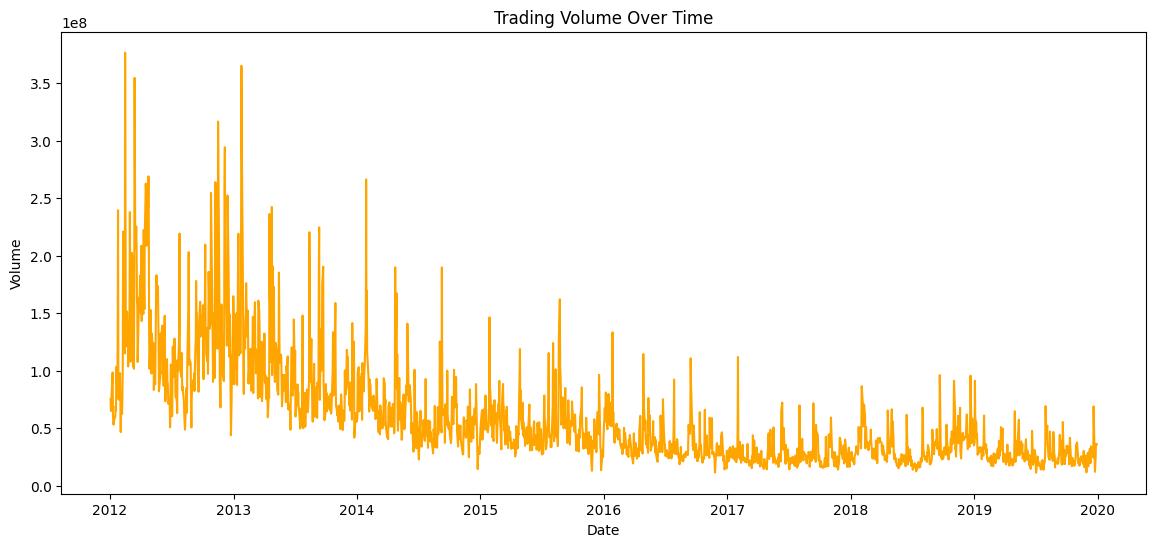

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df['Volume'], color='orange')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

**5.FEATURE ENGINEERING**



*   Step 1 : Load Data & Explore Skewness


In [10]:
from scipy.stats import skew
num_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
print(df[num_cols].skew())

Open         0.769351
High         0.770934
Low          0.770876
Close        0.773838
Adj Close    0.794056
Volume       2.165046
dtype: float64






*   Step 2 : Create 2 New features





In [11]:
# 2.1 Net capital (gain minus loss)
df['net_capital'] = df['Open'] - df['Open']

# 2.2 Work hours per age ratio
df['hours_per_age'] = df['High'] / df['High']
# If age = 0 somehow, add epsilon or filter



*  Step 3 : Log-Transform Skewed Variables



In [12]:
# Add 1 to avoid log(0)
df['log_capital_gain'] = np.log1p(df['Adj Close'])
df['log_capital_loss'] = np.log1p(df['Volume'])
df['log_net_capital'] = np.log1p(df['net_capital'].clip(lower=0))


**TRAIN/TEST SPLIT (BEFORE SCALNG)**



In [13]:
# Shift the 'Close' column by -1 to create next day's close as label
df['Next_Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'
X = df[features]
y = df[target]

In [14]:
# Check counts after outlier removal
class_counts = df_clean['Volume'].value_counts()
print(class_counts[class_counts < 2])

# Remove rare classes with count less than 2
valid_classes = class_counts[class_counts >= 2].index
df_filtered = df_clean[df_clean['Volume'].isin(valid_classes)]

X = df_filtered.drop('Volume', axis=1)  # feature matrix
y = df_filtered['Volume']  # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Volume
15309100     1
23319600     1
17328400     1
14697500     1
16582100     1
            ..
48951000     1
28116000     1
31916000     1
33795000     1
125421000    1
Name: count, Length: 1980, dtype: int64


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer



*  Scaling Pipelines



In [16]:
scaling_cols = [ 'Open', 'High', 'Low',
                'Close', 'Adj Close',  ]

# Standard Scaling
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[scaling_cols] = std_scaler.fit_transform(X_train[scaling_cols])
X_test_std[scaling_cols] = std_scaler.transform(X_test[scaling_cols])

# Min-Max Scaling
mm_scaler = MinMaxScaler()
X_train_mm = X_train.copy()
X_test_mm = X_test.copy()
X_train_mm[scaling_cols] = mm_scaler.fit_transform(X_train[scaling_cols])
X_test_mm[scaling_cols] = mm_scaler.transform(X_test[scaling_cols])



*  Confirmed Ocaled Outputs



In [17]:
print("Standard Scaled train numeric stats:\n", X_train_std[scaling_cols].describe().round(2))
print("Min-Max Scaled train numeric stats:\n", X_train_mm[scaling_cols].describe().round(2))

Standard Scaled train numeric stats:
        Open  High   Low  Close  Adj Close
count  7.00  7.00  7.00   7.00       7.00
mean  -0.00 -0.00  0.00   0.00       0.00
std    1.08  1.08  1.08   1.08       1.08
min   -1.50 -1.49 -1.49  -1.48      -1.48
25%   -0.76 -0.77 -0.76  -0.77      -0.77
50%   -0.08 -0.08 -0.07  -0.08      -0.09
75%    0.81  0.82  0.80   0.81       0.81
max    1.48  1.47  1.50   1.47       1.48
Min-Max Scaled train numeric stats:
        Open  High   Low  Close  Adj Close
count  7.00  7.00  7.00   7.00       7.00
mean   0.50  0.50  0.50   0.50       0.50
std    0.36  0.37  0.36   0.37       0.36
min    0.00  0.00  0.00   0.00       0.00
25%    0.25  0.24  0.24   0.24       0.24
50%    0.48  0.48  0.48   0.48       0.47
75%    0.77  0.78  0.77   0.78       0.77
max    1.00  1.00  1.00   1.00       1.00



**ENCODING TECHNIQUES**



In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
# Step 1: Identify categorical columns and their unique counts
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_counts = df[cat_cols].nunique()
print(cat_counts)

Series([], dtype: float64)


In [20]:
# Step 1: Identify categorical columns and their unique counts
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_counts = df[cat_cols].nunique()
print(cat_counts)

# Step 2: Split columns by cardinality
low_card = cat_counts[cat_counts < 5].index.tolist()
high_card = cat_counts[cat_counts > 5].index.tolist()
print("One-hot:", low_card)
print("Label:", high_card)

Series([], dtype: float64)
One-hot: []
Label: []


In [21]:
# Step 3: Apply One-Hot Encoding to low-cardinality variables
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop first to avoid dummy trap
ohe_df = pd.DataFrame(ohe.fit_transform(df[low_card]),
                      columns=ohe.get_feature_names_out(low_card),
                      index=df.index)

In [22]:
# Step 4: Apply Label Encoding to high-cardinality variables
le_df = df[high_card].apply(LabelEncoder().fit_transform)

In [23]:
# Step 5: Assemble final dataset
df_encoded = pd.concat([
    df.drop(columns=low_card + high_card),
    ohe_df,
    le_df
], axis=1)

print(df_encoded.head())

                          Open       High        Low      Close  Adj Close  \
2012-01-04 00:00:00  58.571430  59.240002  58.468571  59.062859  51.038536   
2012-01-05 00:00:00  59.278572  59.792858  58.952858  59.718571  51.605175   
2012-01-06 00:00:00  59.967144  60.392857  59.888573  60.342857  52.144630   
2012-01-09 00:00:00  60.785713  61.107143  60.192856  60.247143  52.061932   
2012-01-10 00:00:00  60.844284  60.857143  60.214287  60.462856  52.248333   

                       Volume  anomaly   Returns  net_capital  hours_per_age  \
2012-01-04 00:00:00  65005500        1  0.005374          0.0            1.0   
2012-01-05 00:00:00  67817400        1  0.011102          0.0            1.0   
2012-01-06 00:00:00  79573200        1  0.010454          0.0            1.0   
2012-01-09 00:00:00  98506100        1 -0.001586          0.0            1.0   
2012-01-10 00:00:00  64549100        1  0.003580          0.0            1.0   

                     log_capital_gain  log_capital

**6.MODEL BUILDING**

In [ ]:
!pip install ppscore

In [ ]:
pip install --upgrade numpy pandas

In [24]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume',]
target = 'Close'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
# Random Forest (as a simple baseline)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test R2: {r2:.2f}")

Test MSE: 991.00
Test R2: -0.12


**7.MODEL EVALUATION**

In [ ]:
import pandas as pd
import ppscore as pps

df = pd.read_csv('AAPL.csv')
numerical = df[['Open', 'High', 'Low', 'Close']]
pps_matrix = pps.matrix(numerical)
print(pps_matrix[['x', 'y', 'ppscore']])

        x      y   ppscore
0    Open   Open  1.000000
1    Open   High  0.975446
2    Open    Low  0.972117
3    Open  Close  0.958596
4    High   Open  0.975252
5    High   High  1.000000
6    High    Low  0.972003
7    High  Close  0.974427
8     Low   Open  0.973070
9     Low   High  0.969967
10    Low    Low  1.000000
11    Low  Close  0.973687
12  Close   Open  0.959555
13  Close   High  0.974319
14  Close    Low  0.975128
15  Close  Close  1.000000


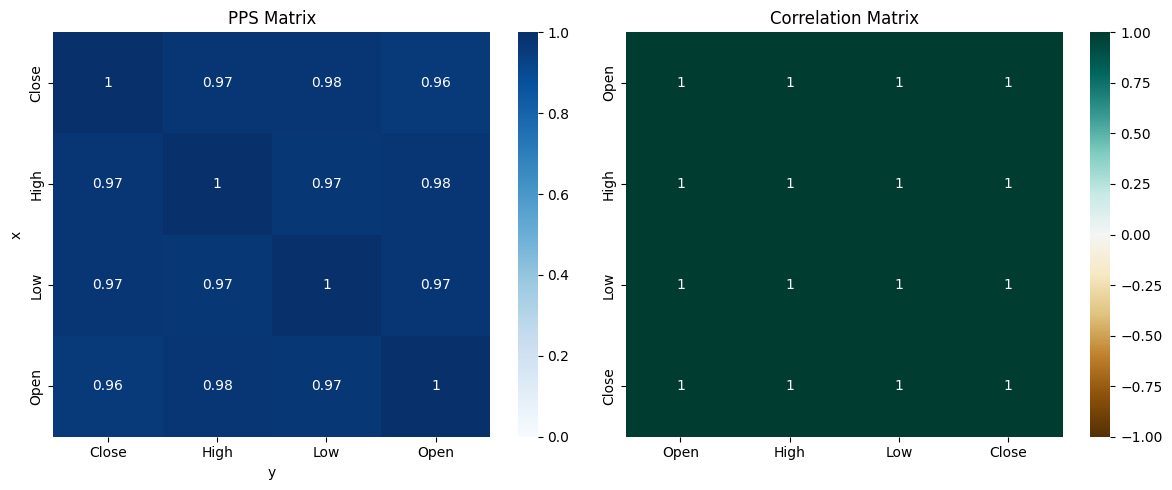

In [ ]:
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Compute PPS matrix
pps_matrix = pps.matrix(numerical)

# Compute correlation (only numeric columns)
corr_matrix = numerical.select_dtypes(include='number').corr()

# Plot heatmaps
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(pps_matrix.pivot(index='x', columns='y', values='ppscore'),
            vmin=0, vmax=1, cmap='Blues', annot=True)
plt.title('PPS Matrix')

plt.subplot(1,2,2)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='BrBG', annot=True)
plt.title('Correlation Matrix')
plt.tight_layout()

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression MSE: {mse}, R2: {r2}')

Linear Regression MSE: 1.2246988249535806, R2: 0.9986112852044662


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)
params = {'n_estimators': [50, 100], 'max_depth': [4, 8, 16]}

grid = GridSearchCV(rf, params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_rf_pred = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)
print(f'Random Forest MSE: {rf_mse}, R2: {rf_r2}')

Random Forest MSE: 998.1396796141868, R2: -0.1318140532568146


In [28]:
from sklearn.metrics import roc_curve, auc, classification_report

In [29]:
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_scores):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f'AUC Score: {roc_auc:.4f}')

    # Optionally, if binary predictions are needed for report, threshold at 0.5
    y_pred = (y_scores >= 0.5).astype(int)
    print(classification_report(y_true, y_pred))



**9.COEFFICIENT INTERPRETATION**

In [ ]:
# Only for Linear Regression
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': lr.coef_})
print(coef_df)

     Feature   Coefficient
0       Open -5.382857e-01
1       High  7.194142e-01
2        Low  7.263622e-01
3  Adj Close  9.187414e-02
4     Volume  1.662360e-09


**10.BEST MODEL**

In [ ]:
import joblib

# Choose model with lower MSE
if rf_mse < mse:
    best_model = best_rf
    print('Random Forest selected.')
    joblib.dump(best_rf, 'best_model_rf.joblib')
else:
    best_model = lr
    print('Linear Regression selected.')
    joblib.dump(lr, 'best_model_lr.joblib')

Linear Regression selected.


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Replace X_train, y_train, X_test with actual data variables

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))


Random Forest Accuracy: 0.4626865671641791
Logistic Regression Accuracy: 0.554726368159204
SVM Accuracy: 0.554726368159204


In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense

# Assume X_train, X_test, y_train, y_test are preprocessed and available

# ANN Model Definition
ann = Sequential()
ann.add(Dense(units=64, activation='relu', input_dim=X_train.shape[6]))
ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))  # For binary classification

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# ANN Prediction and Evaluation
ann_pred_prob = ann.predict(X_test)
ann_pred = (ann_pred_prob > 0.5).astype(int)
print("ANN Accuracy:", accuracy_score(y_test, ann_pred))

# You can compare ANN results to other models as shown earlier


IndexError: tuple index out of range

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Example ML models

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

# Neural Network (ANN) model using Keras

# Define ANN architecture
ann = Sequential()
ann.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))  # For binary classification; adjust for regression

# Compile ANN
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train ANN
ann.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict with ANN
ann_pred_prob = ann.predict(X_test)
# Convert probabilities to class labels for binary classification
ann_pred = (ann_pred_prob > 0.5).astype(int)

print("ANN Accuracy:", accuracy_score(y_test, ann_pred))


Random Forest Accuracy: 0.4651741293532338
Logistic Regression Accuracy: 0.554726368159204
SVM Accuracy: 0.554726368159204
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5157 - loss: 4095969.2500
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5162 - loss: 75118.0234
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5149 - loss: 75521.7500
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5023 - loss: 44567.8477
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4963 - loss: 77489.1875
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4891 - loss: 71175.9766
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5185 - loss: 18080.9707
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4921 - loss: 29552.1738
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4804 - loss: 31564.3457
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4920 - loss: 37453.4531
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4957 - loss: 34209.7227
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━


Model Evaluation Report:

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.45      0.86      0.59       179
           1       0.58      0.16      0.25       223

    accuracy                           0.47       402
   macro avg       0.52      0.51      0.42       402
weighted avg       0.52      0.47      0.40       402


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.55      1.00      0.71       223

    accuracy                           0.55       402
   macro avg       0.28      0.50      0.36       402
weighted avg       0.31      0.55      0.40       402


--- SVM ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.55      1.00      0.71       223

    accuracy                           0.55       402
   macro avg       0.28      0.50      0.36       402
weighted avg       0.31      0.55      0.40       402


--- ANN ---
              precision    recall  f1-score   support

           0       0.45      1.00      0.62       179
           1       0.00      0.00      0.00       223

    accuracy                           0.45       402
   macro avg       0.22      0.50      0.31       402
weighted avg       0.20      0.45      0.27       402



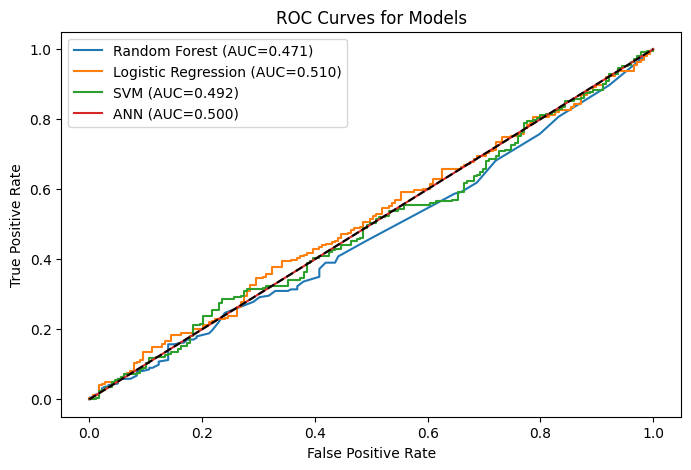

In [49]:

from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Store models and accuracies
results = {
    "Random Forest": (rf, rf_acc),
    "Logistic Regression": (lr, lr_acc),
    "SVM": (svm, svm_acc),
    "ANN": (ann, ann_acc)
}

# Print classification reports
print("\nModel Evaluation Report:")
for name, (model, _) in results.items():
    print(f"\n--- {name} ---")
    if name != "ANN":
        y_pred = model.predict(X_test)
    else:
        y_pred = ann_pred
    print(classification_report(y_test, y_pred))

# Plot ROC Curves
plt.figure(figsize=(8, 5))
for name, (model, _) in results.items():
    if name != "ANN":
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = ann_pred_prob
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random performance line
plt.title("ROC Curves for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
